In [358]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [359]:
hr_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_heart_rate.csv')
hr_df['Time'] = pd.to_datetime(hr_df['Time'])

In [360]:
# resample to minute heart rate values from 15-20s
def get_mean_min_vals(group):
    mean_minute_vals = group.resample('1Min', on='Time')['Value'].mean() 
    return mean_minute_vals.to_frame()
    
hr_per_min_df = hr_df.groupby('Id').apply(get_mean_min_vals)
hr_per_min_df.head()

Value
Id         Time                           
2022484408 2016-04-01 07:54:00   99.600000
           2016-04-01 07:55:00  110.111111
           2016-04-01 07:56:00   92.555556
           2016-04-01 07:57:00   90.400000
           2016-04-01 07:58:00   97.875000

# Combine with minutes activity data

In [361]:
mins_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_activity_minutes.csv')
# removing not needed data fields:
mins_df = mins_df.drop(columns=['Calories', 'METs', 'Steps'])
# rename index for merging
hr_per_min_df.index.names = ['Id', 'ActivityMinute']
mins_df['ActivityMinute'] = pd.to_datetime(mins_df['ActivityMinute'])
mins_df = mins_df.set_index(['Id', 'ActivityMinute'])

hr_intensity_df = pd.merge(hr_per_min_df, mins_df, left_index=True, right_index=True)
hr_intensity_df = hr_intensity_df.reset_index().set_index('Id')
hr_intensity_df.head()

,ActivityMinute,Value,Intensity
Id,,,
2022484408,2016-04-01 07:54:00,99.600000,1
2022484408,2016-04-01 07:55:00,110.111111,1
2022484408,2016-04-01 07:56:00,92.555556,1
2022484408,2016-04-01 07:57:00,90.400000,0
2022484408,2016-04-01 07:58:00,97.875000,1


In [362]:
hr_intensity_df.isna().sum()

ActivityMinute         0
Value             293706
Intensity              0
dtype: int64

In [363]:
# drop null cases - non existant hr values don't provide use for hr indicators
hr_intensity_df = hr_intensity_df.dropna()
hr_intensity_df.isna().sum()

ActivityMinute    0
Value             0
Intensity         0
dtype: int64

In [364]:
# get previous and next values in aim to remove some intensity drops
hr_intensity_df['prev_intensity'] = hr_intensity_df['Intensity'].shift(1)
hr_intensity_df['prev2_intensity'] = hr_intensity_df['Intensity'].shift(2)
hr_intensity_df['prev3_intensity'] = hr_intensity_df['Intensity'].shift(3)

hr_intensity_df['next_intensity'] = hr_intensity_df['Intensity'].shift(-1)
hr_intensity_df['next2_intensity'] = hr_intensity_df['Intensity'].shift(-2)
hr_intensity_df['next3_intensity'] = hr_intensity_df['Intensity'].shift(-3)

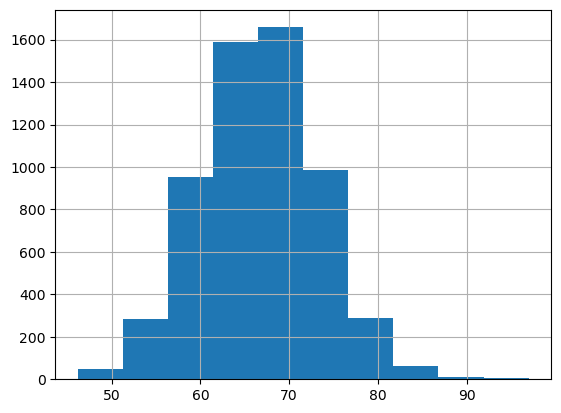

In [365]:
hr_intensity_df = hr_intensity_df.reset_index()
hr_intensity_df[(hr_intensity_df['Id'] == 2022484408) & (hr_intensity_df['Intensity'] == 0) & 
                (hr_intensity_df['prev_intensity'] == 0) & 
                (hr_intensity_df['prev2_intensity'] == 0) &
                (hr_intensity_df['prev3_intensity'] == 0) &
                (hr_intensity_df['next_intensity'] == 0) &
                (hr_intensity_df['next2_intensity'] == 0) &
                (hr_intensity_df['next3_intensity'] == 0)
                ]['Value'].hist()
plt.show()

In [366]:
def get_median_resting_hr(group):
    median_resting_hr = group[(group['Intensity'] == 0) & (group['prev_intensity'] == 0) & 
                                    (group['prev2_intensity'] == 0) &
                                    (group['prev3_intensity'] == 0) &
                                    (group['next_intensity'] == 0) &
                                    (group['next2_intensity'] == 0) &
                                    (group['next3_intensity'] == 0)
                                    ]['Value'].median()
    return median_resting_hr

daily_median_resting_hr = hr_intensity_df.groupby(['Id', hr_intensity_df['ActivityMinute'].dt.date]).apply(get_median_resting_hr)
daily_median_resting_hr

Id          ActivityMinute
2022484408  2016-04-01        66.366667
            2016-04-02        65.000000
            2016-04-03        66.000000
            2016-04-04        63.400000
            2016-04-05        71.775000
                                ...    
8877689391  2016-05-08        66.625000
            2016-05-09        66.750000
            2016-05-10        65.828571
            2016-05-11        63.142857
            2016-05-12        62.162500
Length: 469, dtype: float64

In [367]:
daily_median_resting_hr.name = 'Daily Av Resting Hr'
daily_median_resting_hr_df = daily_median_resting_hr.to_frame()
daily_median_resting_hr_df

Daily Av Resting Hr
Id         ActivityMinute                     
2022484408 2016-04-01                66.366667
           2016-04-02                65.000000
           2016-04-03                66.000000
           2016-04-04                63.400000
           2016-04-05                71.775000
...                                        ...
8877689391 2016-05-08                66.625000
           2016-05-09                66.750000
           2016-05-10                65.828571
           2016-05-11                63.142857
           2016-05-12                62.162500

[469 rows x 1 columns]

In [368]:
def get_daily_total_intensity(group):
    return group['Intensity'].sum()

total_daily_intensity = hr_intensity_df.groupby(['Id', hr_intensity_df['ActivityMinute'].dt.date]).apply(get_daily_total_intensity)
total_daily_intensity

Id          ActivityMinute
2022484408  2016-04-01        459
            2016-04-02        236
            2016-04-03        398
            2016-04-04        455
            2016-04-05        480
                             ... 
8877689391  2016-05-08        304
            2016-05-09        474
            2016-05-10        299
            2016-05-11        501
            2016-05-12        188
Length: 469, dtype: int64

In [369]:
total_daily_intensity.name = 'Daily Total Intensity'
total_daily_intensity_df = total_daily_intensity.to_frame()
total_daily_intensity_df

Daily Total Intensity
Id         ActivityMinute                       
2022484408 2016-04-01                        459
           2016-04-02                        236
           2016-04-03                        398
           2016-04-04                        455
           2016-04-05                        480
...                                          ...
8877689391 2016-05-08                        304
           2016-05-09                        474
           2016-05-10                        299
           2016-05-11                        501
           2016-05-12                        188

[469 rows x 1 columns]

In [370]:
resting_hr_intensity_df = pd.merge(daily_median_resting_hr_df, total_daily_intensity_df, left_index=True, right_index=True)
resting_hr_intensity_df.head()


Daily Av Resting Hr  Daily Total Intensity
Id         ActivityMinute                                            
2022484408 2016-04-01                66.366667                    459
           2016-04-02                65.000000                    236
           2016-04-03                66.000000                    398
           2016-04-04                63.400000                    455
           2016-04-05                71.775000                    480

In [371]:
resting_hr_intensity_df.isna().sum()

Daily Av Resting Hr      3
Daily Total Intensity    0
dtype: int64

In [372]:
resting_hr_intensity_df = resting_hr_intensity_df.dropna()
resting_hr_intensity_df.isna().sum()

Daily Av Resting Hr      0
Daily Total Intensity    0
dtype: int64

In [373]:
resting_hr_intensity_df = resting_hr_intensity_df.reset_index()
resting_hr_intensity_df = resting_hr_intensity_df[['Daily Av Resting Hr', 'Daily Total Intensity']]
resting_hr_intensity_df.head()

,Daily Av Resting Hr,Daily Total Intensity
0,66.366667,459
1,65.000000,236
2,66.000000,398
3,63.400000,455
4,71.775000,480


In [374]:
resting_hr_intensity_df.describe()

,Daily Av Resting Hr,Daily Total Intensity
count,466.000000,466.000000
mean,67.804786,347.347639
std,8.789482,166.186925
min,51.000000,0.000000
25%,61.700000,233.250000
50%,66.900000,360.000000
75%,72.325000,453.500000
max,101.309524,904.000000


# Feature Scaling and Transformation

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_66579/3753544345.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  resting_hr_intensity_df.hist(ax=axis, bins=20)


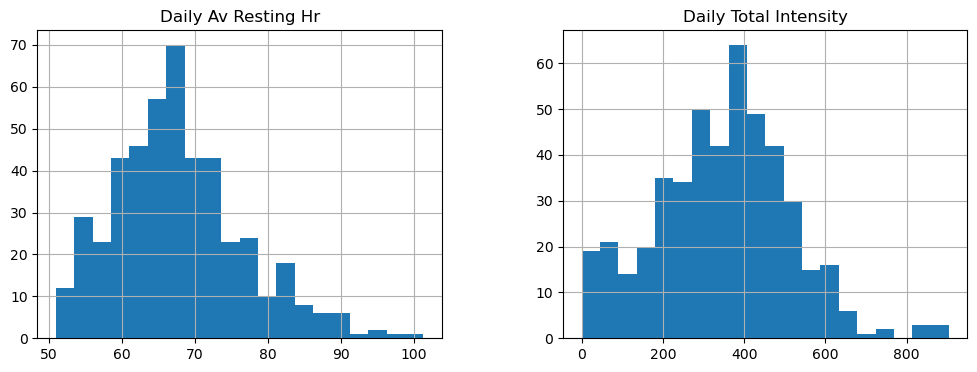

In [375]:
# inspecting the distribution of each feature:
fig, axis = plt.subplots(figsize=(12, 4))
resting_hr_intensity_df.hist(ax=axis, bins=20)
plt.show()

In [376]:
resting_hr_intensity_df.skew()

Daily Av Resting Hr      0.677695
Daily Total Intensity    0.138496
dtype: float64

In [377]:
before_unskewed_df = resting_hr_intensity_df.copy() #(for comparison after)

def box_cox_transformation(feature, l):
    transform = ColumnTransformer(transformers=[("box-cox", FunctionTransformer(lambda X: stats.boxcox(X, lmbda=l)), [feature])])
    # return pd.DataFrame(transform.fit_transform(activity_steps_df))
    return transform.fit_transform(resting_hr_intensity_df)

In [378]:
resting_hr_intensity_df['Daily Av Resting Hr'] = box_cox_transformation(feature="Daily Av Resting Hr", l=-0.9)
resting_hr_intensity_df['Daily Total Intensity'] = box_cox_transformation(feature="Daily Total Intensity", l=0.93)

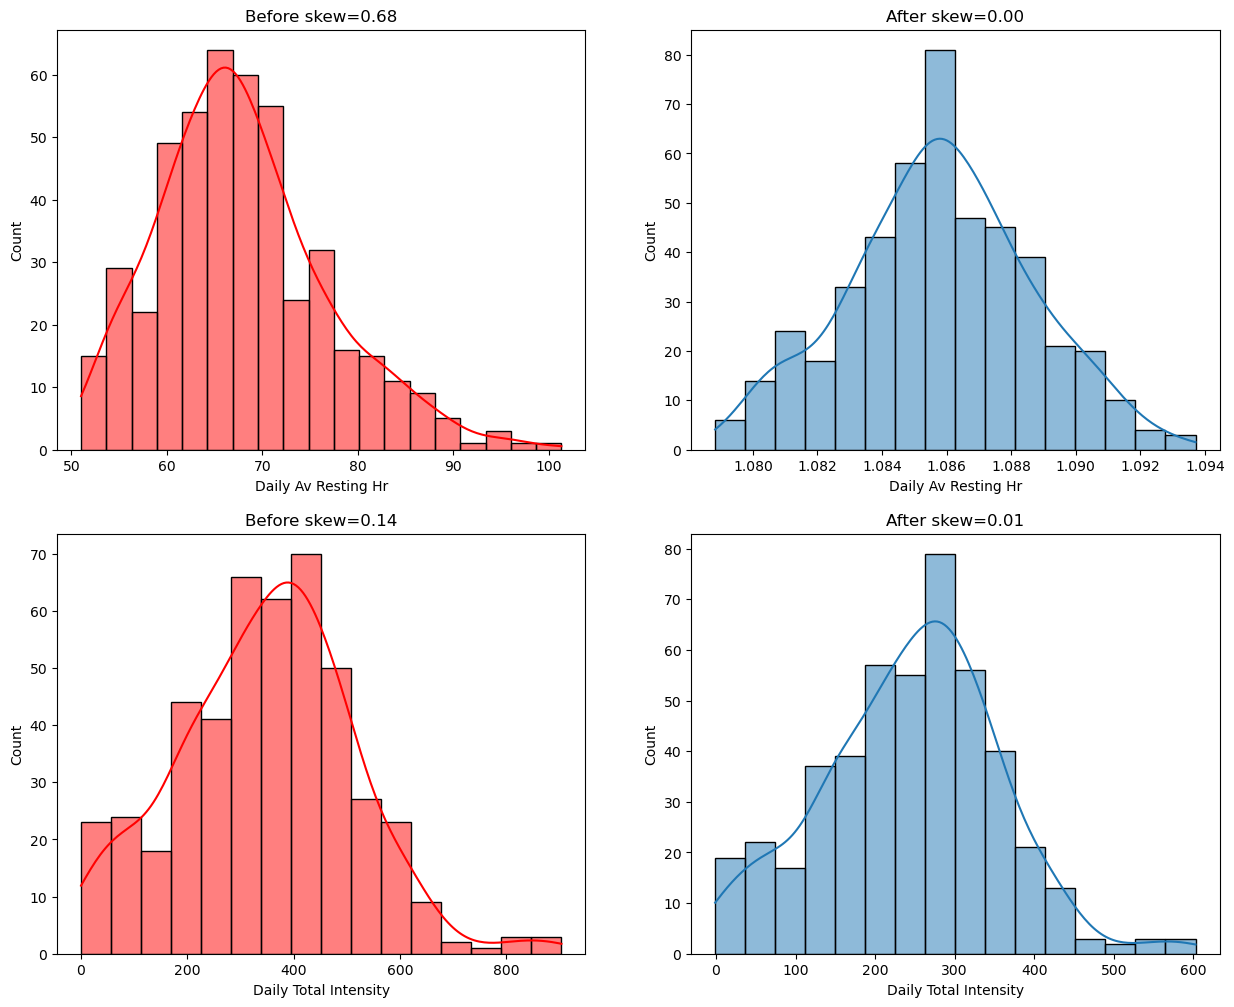

In [379]:

fig, ax = plt.subplots(2, 2, figsize=(15,12))
# activity_steps_df.hist(ax=ax, bins=20)
sns.histplot(before_unskewed_df['Daily Av Resting Hr'], kde=True, ax=ax[0,0], color='red').set(title=f"Before skew={before_unskewed_df['Daily Av Resting Hr'].skew():0.2f}")
sns.histplot(resting_hr_intensity_df['Daily Av Resting Hr'], kde=True, ax=ax[0,1]).set(title=f"After skew={resting_hr_intensity_df['Daily Av Resting Hr'].skew():0.2f}")

sns.histplot(before_unskewed_df['Daily Total Intensity'], kde=True, ax=ax[1,0], color='red').set(title=f"Before skew={before_unskewed_df['Daily Total Intensity'].skew():0.2f}")
sns.histplot(resting_hr_intensity_df['Daily Total Intensity'], kde=True, ax=ax[1,1]).set(title=f"After skew={resting_hr_intensity_df['Daily Total Intensity'].skew():0.2f}")

plt.show()

In [380]:
resting_hr_intensity_df.describe()

,Daily Av Resting Hr,Daily Total Intensity
count,466.000000,466.000000
mean,1.085785,244.745995
std,0.002845,111.438672
min,1.078830,-1.075269
25%,1.083915,170.159180
50%,1.085825,255.301327
75%,1.087539,316.710087
max,1.093706,602.530931


# Scaling the features

In [381]:
scaler = StandardScaler()
scaled_intensity_hr = scaler.fit_transform(resting_hr_intensity_df)
scaled_intensity_hr

array([[-4.99268433e-02,  6.78652089e-01],
       [-2.19344961e-01, -6.53168100e-01],
       [-9.47261213e-02,  3.20100757e-01],
       [-4.26494655e-01,  6.55247743e-01],
       [ 5.60219817e-01,  8.01293763e-01],
       [ 1.44052620e-01,  8.18782970e-01],
       [ 7.61794059e-01,  1.43218902e+00],
       [ 1.24665505e-01,  5.67352004e-01],
       [ 7.15515673e-01,  7.19575430e-01],
       [-2.19344961e-01,  2.55049525e-01],
       [ 1.44052620e-01,  4.91006075e-01],
       [-5.12548098e-01,  2.01729590e-01],
       [-2.27254670e-01,  5.08638632e-01],
       [-8.03141829e-01,  8.88703471e-02],
       [-9.47261213e-02,  2.13586072e-01],
       [-4.26257927e-01, -2.88490303e-01],
       [ 4.24396663e-01,  7.60455761e-01],
       [ 2.20706689e-01,  6.90348902e-01],
       [ 2.23418187e-01,  7.69664606e-02],
       [ 5.82078822e-02,  1.18437311e+00],
       [ 5.57600708e-01,  1.91273155e+00],
       [-2.78450240e-01,  6.20114167e-01],
       [-4.46425141e-01, -5.73653298e-01],
       [ 1.

In [382]:
scaled_intensity_hr_df = pd.DataFrame(scaled_intensity_hr, columns=resting_hr_intensity_df.columns)
scaled_intensity_hr_df

,Daily Av Resting Hr,Daily Total Intensity
0,-0.049927,0.678652
1,-0.219345,-0.653168
2,-0.094726,0.320101
3,-0.426495,0.655248
4,0.560220,0.801294
...,...,...
461,-0.018645,-0.240282
462,-0.003591,0.766292
463,-0.115834,-0.270402
464,-0.460716,0.923560


In [383]:
scaled_intensity_hr_df.describe()

,Daily Av Resting Hr,Daily Total Intensity
count,4.660000e+02,4.660000e+02
mean,-2.630228e-14,1.067339e-16
std,1.001075e+00,1.001075e+00
min,-2.447193e+00,-2.208259e+00
25%,-6.577667e-01,-6.700275e-01
50%,1.438565e-02,9.482055e-02
75%,6.174046e-01,6.464671e-01
max,2.787624e+00,3.214050e+00


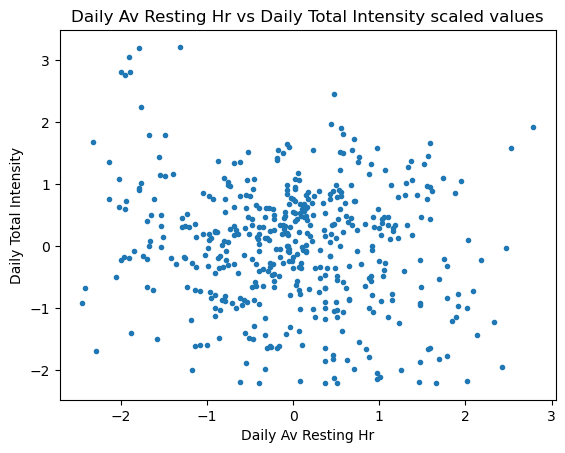

In [387]:
plt.plot(scaled_intensity_hr_df['Daily Av Resting Hr'].values, scaled_intensity_hr_df['Daily Total Intensity'].values, '.')
plt.xlabel('Daily Av Resting Hr')
plt.ylabel('Daily Total Intensity')
plt.title('Daily Av Resting Hr vs Daily Total Intensity scaled values')
plt.show()

# K-means clustering

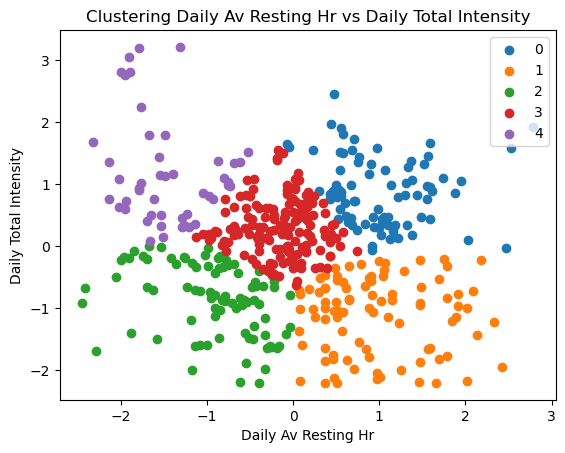

In [390]:
kmeans_labels = KMeans(n_clusters=5, random_state=0).fit_predict(scaled_intensity_hr_df.values)
u_labels = np.unique(kmeans_labels)
for i in u_labels:
    plt.scatter(scaled_intensity_hr_df[kmeans_labels == i]['Daily Av Resting Hr'], scaled_intensity_hr_df[kmeans_labels == i]['Daily Total Intensity'] , label = i)
plt.legend()

plt.title("Clustering Daily Av Resting Hr vs Daily Total Intensity")
plt.xlabel('Daily Av Resting Hr')
plt.ylabel('Daily Total Intensity')
plt.show()